# Features de Imagem: Scikit-Image

## 1) HOG: Histogram of Oriented Gradients

O Histograma de Gradientes Orientados é um descritor muito utilizado para detecção de objetos, visto que ele descreve características de forma através da distribuição (histograma) das direções do gradiente (gradientes orientados). 

O código abaixo é uma adaptação retirada da documentação do Scikit-Image, que pode ser encontrada em:<br>
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

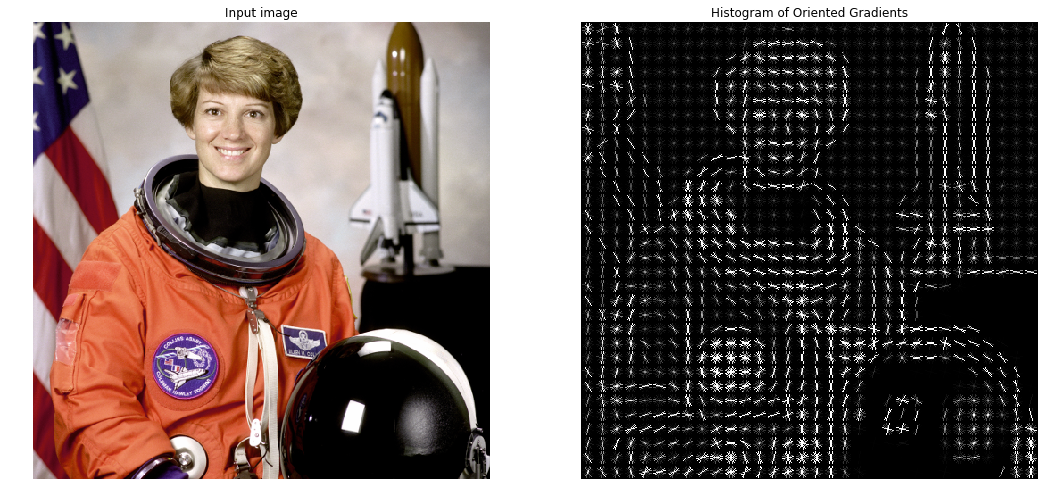

In [3]:
import matplotlib.pyplot as plt

from skimage import color
from skimage.feature import hog
from skimage import data, exposure

%matplotlib inline

### Load Image ###
image = data.astronaut()
##################

### Extract hog descriptor ###
cell_size = (16, 16)
fd, hog_image = hog(image, orientations=8, pixels_per_cell=cell_size, cells_per_block=(1, 1), visualize=True, multichannel=True)
##############################

### Plot Results ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()
#####################

### Olhando mais de perto...

Para melhor visualização, selecionamos uma região da imagem composta por células homogêneas e células com gradientes bem definidos. Note que a magnitude dos bins do descritor é compatível com a direção do gradiente na imagem original, e.g. bordas diagonais na imagem ativam com maior intensidade o bin de orientação correspondente.

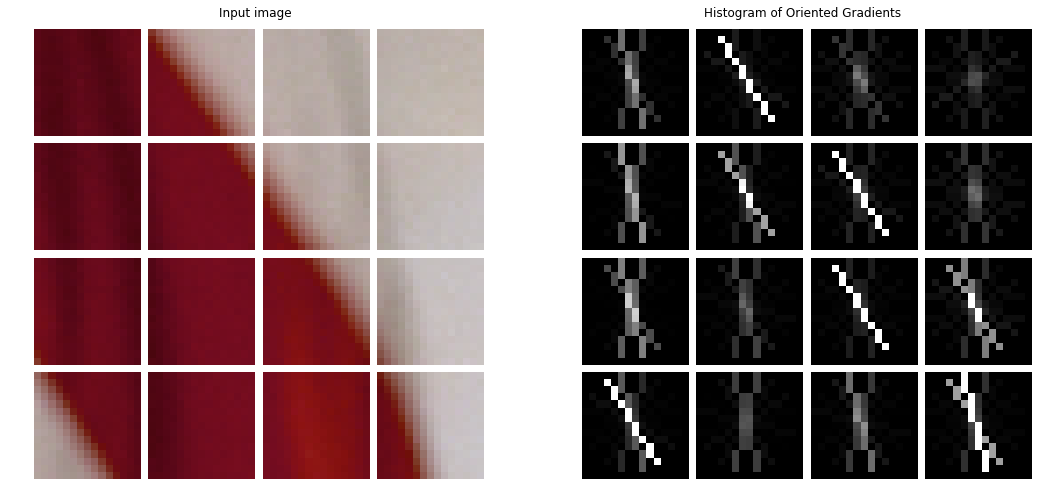

In [4]:
# patch = (0, 32, 0, 32)
patch = (128, 192, 32, 96)

patch_img = image[patch[0]:patch[1], patch[2]:patch[3]]
patch_hog = hog_image_rescaled[patch[0]:patch[1], patch[2]:patch[3]]

for i in range(0, patch[1] - patch[0], cell_size[0]):
    patch_img[i, :, :] = 255
    patch_hog[i, :] = 1.0

for j in range(0, patch[3] - patch[2], cell_size[1]):
    patch_img[:, j, :] = 255
    patch_hog[:, j] = 1.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(patch_img, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(patch_hog, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

## 2) Gabor Filter Banks

O banco de filtros Gabor (criado por Dennis Gabor), é geralmente aplicado ao problema de classificação de texturas. Como o nome sugere, trata-se de um conjunto de múltiplos kernels, cada qual extraindo uma informação específica da imagem. Os filtros representam diferentes orientações $\theta$ e frequências $f$ do conteúdo da imagem e, quando combinados, são apropriados para a representação e classificação de texturas.

<img src="figs/gabor.png" style="width: 400px;">

O código a seguir é uma adaptação da documentação do Scikit-Image e pode ser encontrado nos seguintes locais: <br>
- http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabors_from_astronaut.html 
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: grass


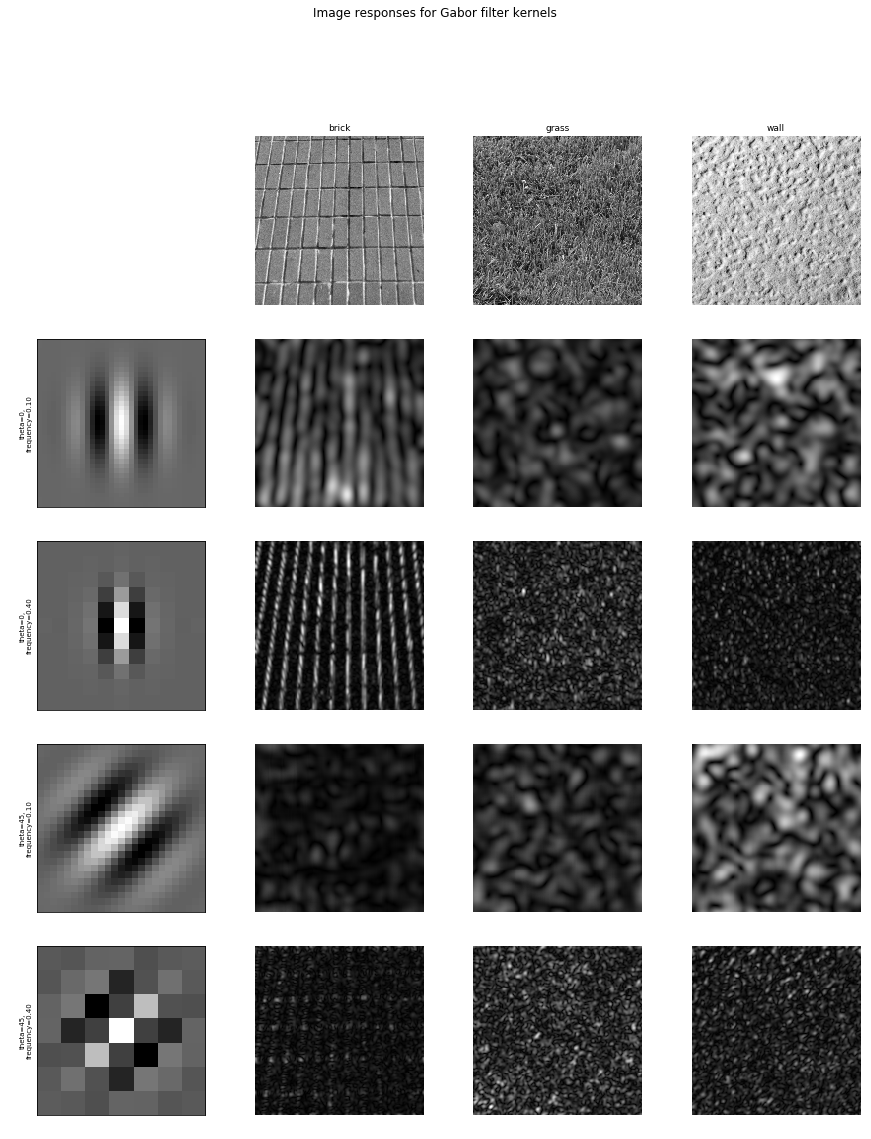

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

%matplotlib inline

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(wall, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 18))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

## 3) GLCMs: Grey Level Co-occurence Matrices

O GLCM é um método estatístico para análise de textura, através da relação espacial entre pixels. Cria-se uma matriz de co-ocorrência de níveis de cinza para analisar com que frequência um pixel de intensidade $i$ co-ocorre com um pixel de intensidade $j$ dentro de um contexto espacial limitado. 

O código a seguir foi adaptado da documentação do Scikit-Image, publicado em: <br> 
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

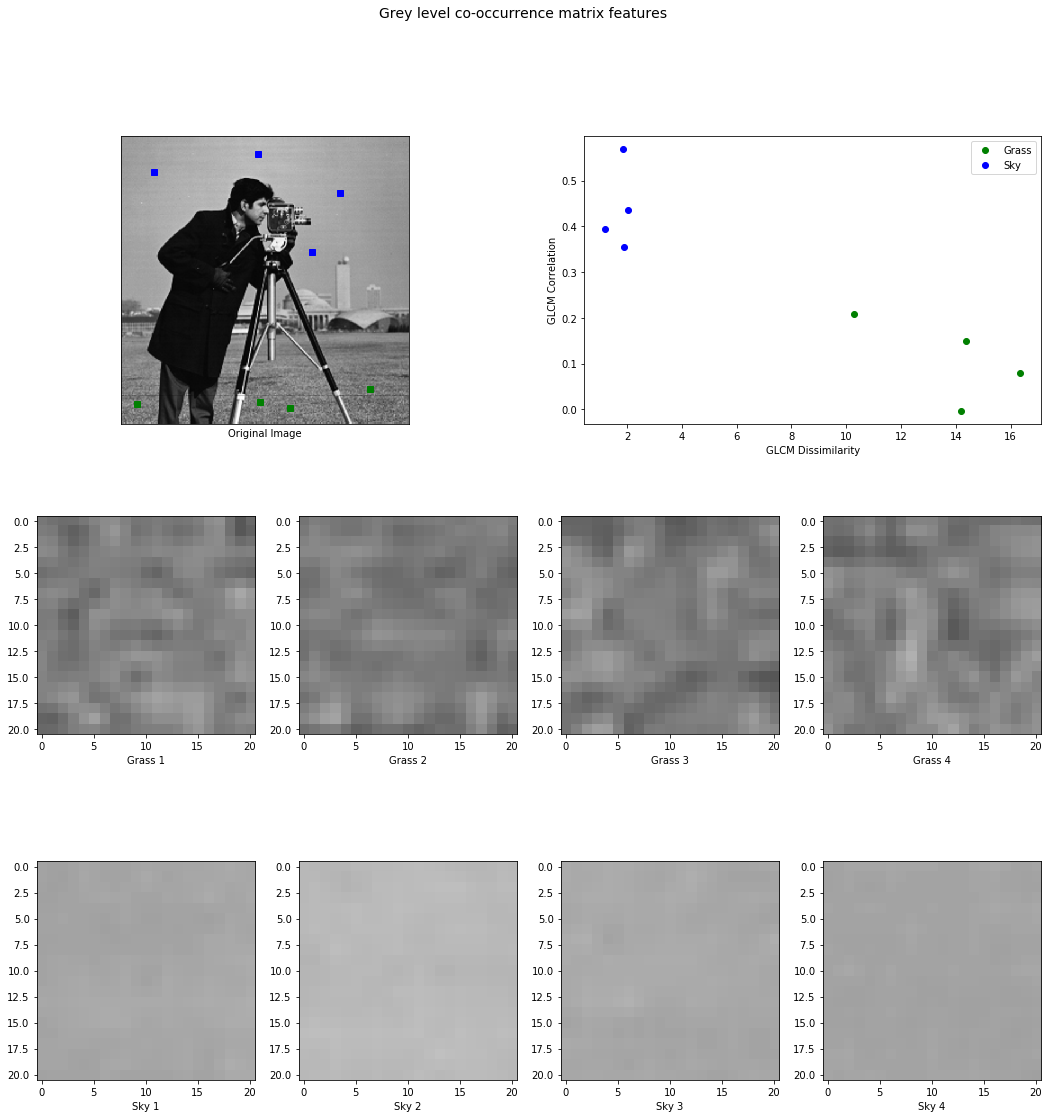

In [5]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data

%matplotlib inline

PATCH_SIZE = 21

# open the camera image
image = data.camera()

# select some patches from grassy areas of the image
grass_locations = [(474, 291), (440, 433), (466, 18), (462, 236)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(54, 48), (21, 233), (90, 380), (195, 330)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(18, 18))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax = fig.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

## 4) Dense DAISY

Descritor de imagem local baseado em histogramas de orientação de gradiente, que realiza rápida extração densa de características. Ideal para compor representações intermediárias de BoF (Bag of Features). Inspirado no SIFT e na sua capacidade de realizar computações densas, o Daisy aprimorou a sua performance incorporando também características do Gradient Location and Orientation Histogram (GLOH).

O código a seguir foi adaptado de: <br>
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_daisy.html

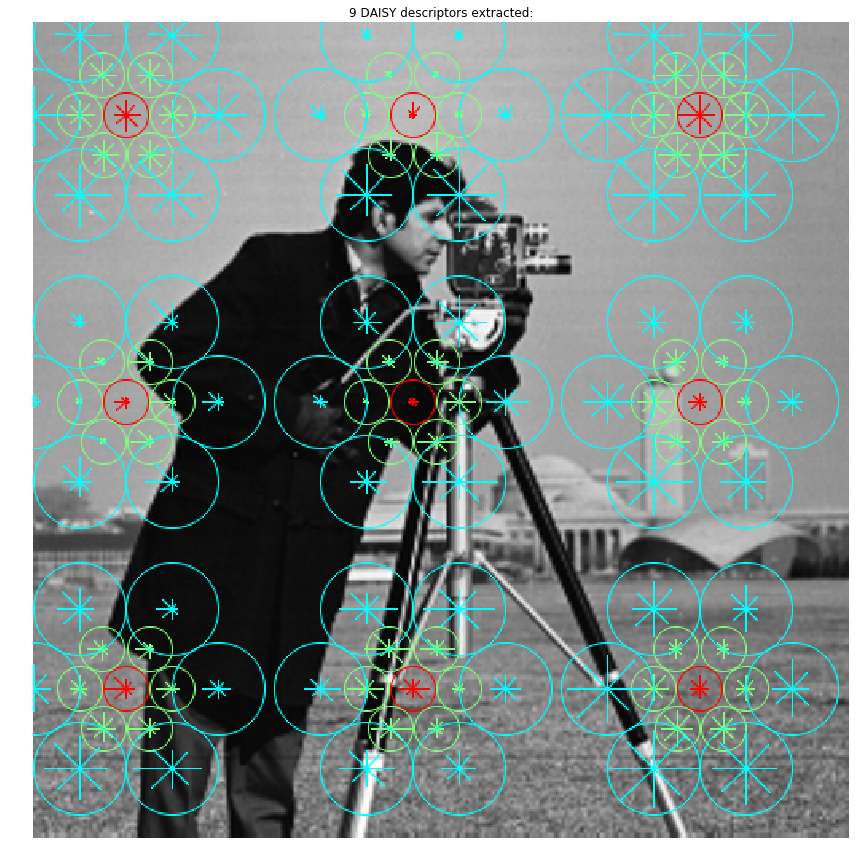

In [6]:
from skimage.feature import daisy
from skimage import data

import matplotlib.pyplot as plt

%matplotlib inline

img = data.camera()
descs, descs_img = daisy(img, step=180, radius=58, rings=2, histograms=6,
                         orientations=8, visualize=True)

fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

## 5) LBP: Local Binary Pattern

Dado um pixel central, o LBP compara os pixels ao redor testando a relação entre as intensidades. Sua resposta é binária indicando se os pixels ao redor são maiores ($1$) ou menores ($0$) que o pixel central. 

A imagem abaixo é um plot de diferentes padrões comumente encontrado em imagens, sob a perspectiva das ativações do LBP. O código que gera a figura pode ser encontrado em: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
<img src="figs/lbp.png">

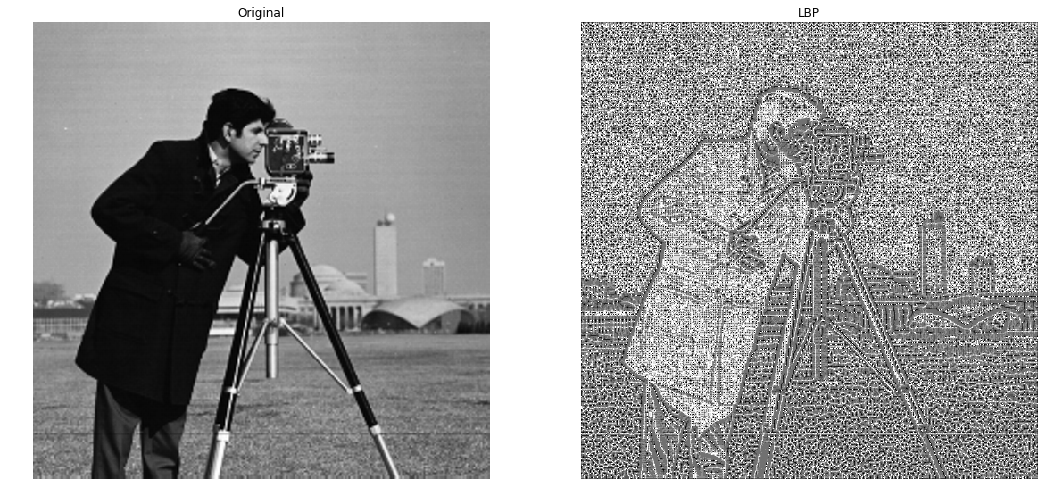

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import feature
from skimage import data

%matplotlib inline

img = data.camera()

lbp = feature.local_binary_pattern(img, 8, 1, method = 'uniform')

fig, ax = plt.subplots(1, 2, figsize=(18, 10))

ax[0].axis('off')
ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].axis('off')
ax[1].imshow(lbp)
ax[1].set_title('LBP')

plt.show()

## No próximo script...
As features aqui aprendidas serão utilizadas para classificação de imagens.